In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from scipy import ndimage
from scipy.optimize import curve_fit
import etpof
from tqdm import tqdm
from tqdm import trange

# %matplotlib widget

In [2]:
res_avg = np.mean([4.88918152, 4.88946346])
res_std = np.mean([0.00183618, 0.00167924])

In [3]:
def remove_hits(img, mode):
    
    # Define different kernels
    if mode == 'single':
        kernel = np.array([[ 0, -1,  0],
                           [-1, +1, -1],
                           [ 0, -1,  0]])
    elif mode == 'horizontal':
        kernel = np.array([[ -1, -1,  -1],
                           [ 0, +1,  0],
                           [ -1, -1,  -1]])
    elif mode == 'vertical':
        kernel = np.array([[ -1,  0,  -1],
                           [-1, +1, -1],
                           [ -1,  0,  -1]])
    else:
        raise ValueError('Mode not recognized')
    
    # Binarize the image
    img_binary = cv.threshold(img, 0, 255, cv.THRESH_BINARY)[1]
    
    # Perform a hit-or-miss transform on a binary version to remove matching pixels
    img_singles = cv.morphologyEx(img_binary, cv.MORPH_HITMISS, kernel)
    
    # Edit the original image
    img[img_singles == 255] = 0
    
    return img


def remove_background(img, cnts=None, sigma_color1=50, sigma_space1=9,
                      sigma_color2=20, sigma_space2=3, noise_threshold=50):
    
    
    # If contours are not given, clean up the image
    if cnts is None:
                
        # Apply a bilateral filter to TODO: explain how the bilateral filter works
        img_proc = cv.bilateralFilter(img, d=-1, sigmaColor=sigma_color1, sigmaSpace=sigma_space1)
        
        # Apply another bilateral filter for finer detail removal
        img_proc = cv.bilateralFilter(img_proc, d=-1, sigmaColor=sigma_color2, sigmaSpace=sigma_space2)
    
        # Set all pixels below a certain threshold to zero with a to-zero threshold
        _, img_proc = cv.threshold(img_proc, noise_threshold, 255, cv.THRESH_TOZERO)
    
        # Remove a bunch of specific patterns
        img_proc = remove_hits(img_proc, 'horizontal')
        img_proc = remove_hits(img_proc, 'vertical')
        img_proc = remove_hits(img_proc, 'single')
        
    # If contours are provided, remove all pixels but them
    else:
        # Create a mask of the contours and their interiors
        mask = np.zeros_like(img)
        mask = cv.drawContours(mask, cnts, -1, 255, -1)
        
        # Set the pixels outside the contours to zero
        img_proc = np.where(mask == 255, img, 0)

    return img_proc

In [4]:
# # Draw the contours with random colours
# img_cnt = img_rgb.copy()
# for cnt in cnts:
#     color = np.random.randint(85, 255, 3, dtype=np.uint8)
#     img_cnt = cv.drawContours(img_cnt, cnt, -1, 
#                                (int(color[0]), int(color[1]), int(color[2])), 2)

In [5]:
def find_local_max(all_idxs, all_ints, min_intensity=100):
    # Maximum filter on this (processed) region
    peak_intensities = ndimage.maximum_filter(all_ints, size=3)
    
    # Filter out maxima of 0 at the edges
    peak_intensities = np.where(peak_intensities == 0, -1, peak_intensities)
    
    # Filter out maxima that are too small
    peak_intensities = np.where(peak_intensities < min_intensity, -1, peak_intensities)
    
    # Get indices
    peak_indices = all_idxs[:, all_ints == peak_intensities]
    
    # Get the intensities of the maxima
    peak_intensities = all_ints[all_ints == peak_intensities]
    
    # If no maxima were detected
    if peak_indices.shape[1] == 0:
        # Raise an exception
        return None, None

    return peak_indices, peak_intensities


def remove_sublists(list_of_lists):
    """
    Remove sublists and duplicates from a list of lists.
    Source: https://www.geeksforgeeks.org/python-remove-sublists-that-are-present-in-another-sublist/
    
    ARGUMENTS:
        list_of_lists: list of lists (might be inhomogeneous)
    
    RETURNS:
        results: list of lists with sublists removed
    """
    
    # Convert each element to a set and sort by descending length
    current_sublist = []
    results = []   
    for element in sorted(map(set, list_of_lists), key = len, reverse = True):
        
        # Add only sets that are not already part of current_sublist
        if not any(element <= number for number in current_sublist):
            current_sublist.append(element)
            results.append(list(element))
         
    return results


def split_clusters(peak_idxs, neighbor_dist=1.5):
    
    # Check the Euclidian distances between the maxima
    dists = etpof.all_distances(peak_idxs[0, :], peak_idxs[1, :])
    
    # Get the indices of all the groups that are within a certain distance
    peak_clusters = [[i for i, val in enumerate(dists[:, col]) 
                 if val < neighbor_dist] for col in range(dists.shape[1])]
    
    # Remove subsets and duplicates
    peak_clusters = remove_sublists(peak_clusters)
       
    return peak_clusters


def extract_neighbors(peak_idxs, peak_idxs_new, peak_ints_new, neighbor_dist=1.5):
    
    # Initialize an empty list to store the indices of peak_idxs_new that are within 1 pixel distance
    indices_within_1_pixel = []
    
    # Iterate over each point in peak_idxs_new
    for i, point_new in enumerate(peak_idxs_new.T):
        # Calculate the Euclidean distance to all points in peak_indices
        distances = np.sqrt(np.sum((peak_idxs - point_new.reshape(-1, 1))**2, axis=0))
        
        # If the minimum distance is less than or equal to a given distance, append the index to indices_within_1_pixel
        if np.min(distances) <= neighbor_dist:
            indices_within_1_pixel.append(i)
    
    # Select the points from peak_idxs_new that are within 1 pixel distance
    peak_idxs_new = peak_idxs_new[:, indices_within_1_pixel]
    
    # Also get the corresponding intensities
    peak_ints_new = peak_ints_new[indices_within_1_pixel]
    
    return peak_idxs_new, peak_ints_new


def destroy_neighbors(box_indices, box_intensities, peak_indices, peak_intensities, max_iter=3, neighbor_dist=2):
      
    # If there are (still) neighbors in the set of maxima...
    iteration = 0
    while peak_indices.shape[1] > 1:

        # Perform a small Gaussian blur on the region
        box_intensities = cv.GaussianBlur(box_intensities, (3, 3), 0,
                                          borderType=cv.BORDER_CONSTANT)

        # Get the new local maxima
        peak_indices_new, peak_intensities_new = find_local_max(box_indices, box_intensities)
        
        # Delete any maxima that are not direct (diagonal) neighbours from the original set
        peak_indices, peak_intensities = extract_neighbors(peak_indices, peak_indices_new, peak_intensities_new, neighbor_dist=neighbor_dist)
        
        # Count the number of iterations
        iteration += 1
        
        # If the max number of iterations is reached...
        if iteration >= max_iter:
            # # Throw a warning
            # print('Maximum number of blurring iterations reached...')
            
            # Pick the first maximum and break the loop
            peak_indices = peak_indices[:, [0]]
            peak_intensities = peak_intensities[[0]]
            break
        
    return peak_indices, peak_intensities


In [6]:
def fit_gaussian_2d(box_indices, box_intensities, peak_index, peak_spread=None):
       
    # Define a Gaussian function to be used for fitting
    if peak_spread is None:
        peak_spread = [1, 1]

    def gaussian(x, a, x0, sigma):
        return a * np.exp(-((x - x0)**2) / (2 * sigma**2))
    
    # Define a set of slices around the peak in 2 directions
    x_indices = box_indices[1, peak_index[0], :].flatten()
    z_indices = box_indices[0, :, peak_index[1]].flatten()
    
    # Get the corresponding intensities 
    x_intensities = box_intensities[peak_index[0], :].flatten()
    z_intensities = box_intensities[:, peak_index[1]].flatten()
    
    # Define initial parameters
    peak_height = box_intensities[peak_index[0], peak_index[1]]
    peak_sigma = peak_spread
    
    # Optimize the parameters
    x_parameters, x_covariance = curve_fit(gaussian, x_indices, x_intensities, 
                                         p0=[peak_height, peak_index[1], peak_sigma[0]])
    z_parameters, z_covariance = curve_fit(gaussian, z_indices, z_intensities, 
                                         p0=[peak_height, peak_index[0], peak_sigma[1]])
    
    # Get the standard errors
    x_errors = np.sqrt(np.diag(x_covariance))
    z_errors = np.sqrt(np.diag(z_covariance))
    
    # Get the optimized peak indices (to be converted back to coordinates)
    peak_fitted_index = np.array([z_parameters[1], x_parameters[1]])
    peak_fitted_intensity = np.array([z_parameters[0], x_parameters[0]])
    
    # Get the errors
    peak_fitted_index_std = np.array([z_errors[1], x_errors[1]])
    peak_fitted_intensity_std = np.array([z_errors[0], x_errors[0]])
    
    # # Plot the box intensities with the fitted Gaussian
    # fig, ax = plt.subplots()
    # ax.plot(x_indices, x_intensities, 'b+', label='x')
    # ax.plot(z_indices, z_intensities, 'r+', label='z')
    # ax.plot(x_indices, gaussian(x_indices, *x_parameters), 'b-', label='x fit')
    # ax.plot(z_indices, gaussian(z_indices, *z_parameters), 'r-', label='z fit')
    # ax.legend()
    
    return (peak_fitted_index, peak_fitted_intensity,
            peak_fitted_index_std, peak_fitted_intensity_std)

In [7]:
# def detect_particles()
    
    

In [8]:
imgs, files = etpof.read_image_series('PTV', 'a')

100%|██████████| 200/200 [00:00<00:00, 238.66it/s]


100%|██████████| 200/200 [00:02<00:00, 69.92it/s]


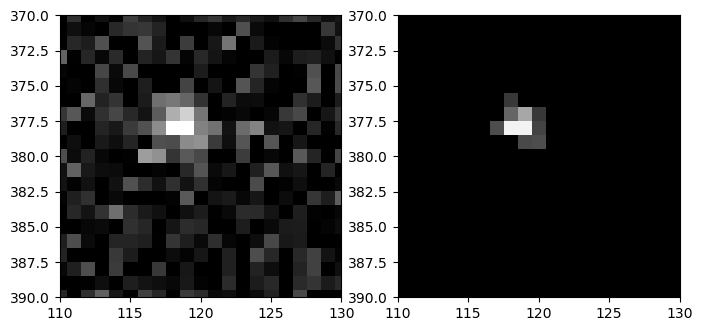

In [9]:
imgs_nobg = [remove_background(img) for img in tqdm(imgs)]

# Show the image and the processed image next to each other
fig, ax = plt.subplots(1,2, figsize = (8, 8))
ax[0].imshow(imgs[48], cmap = 'gray')
ax[1].imshow(imgs_nobg[48], cmap = 'gray')
ax[0].set_xlim(110, 130); ax[0].set_ylim(390, 370)
ax[1].set_xlim(110, 130); ax[1].set_ylim(390, 370)
plt.show()

In [43]:
def find_particle_center(img, cnts, cnt_idx, min_intensity=100, neighbor_dist=2,
                         box_margin=2, max_iter=3, plot_mult=False, plot_all=False):    
    """
    Find the center of a particle at a contour in an image using subpixel fitting.

    ARGUMENTS:
        img: The original image
        cnts: The contours of the particles
        cnt_idx: The index of the contour to be analyzed
        min_intensity: The minimum intensity of a local maximum
        neighbor_dist: The maximum distance between local maxima to be considered part of the same cluster
        box_margin: The margin around the bounding box of the contour
        max_iter: The maximum number of iterations to remove neighbouring maxima
        plot_mult: Whether to plot the contours with multiple clusters
        plot_all: Whether to plot all contours
        
    RETURNS:
        peak_coords_fit: The subpixel coordinates of the maxima
        peak_intensity_fit: The subpixel intensities of the maxima
        peak_coords_err: The errors in the subpixel coordinates of the maxima
        peak_intensity_err: The errors in the subpixel intensities of the maxima
    """

    # === 1: GETTING THE BOUNDING BOX ===
    # Get the contour and calculate its bounding box
    cnt = cnts[cnt_idx]
    box_x, box_z, box_w, box_h = cv.boundingRect(cnt)
    
    # Get the indices of the box pixels as a 2D array
    box_indices = np.indices((box_h + 2 * box_margin, box_w + 2 * box_margin))
    
    # Set all pixels not on this particular contour to black
    img_nobg = remove_background(img, [cnt])
    
    print(img_nobg.shape)
    print((box_z - box_margin))
    print((box_z + box_h + box_margin))
    print((box_x - box_margin))
    print((box_x + box_w + box_margin))

    print(box_h + 2 * box_margin, box_w + 2 * box_margin)
    
    # Get the intensities of the box pixels of the background-less contour and the unedited image as a 2D array
    box_intensities_nobg = (img_nobg[(box_z - box_margin):(box_z + box_h + box_margin),
                            (box_x - box_margin):(box_x + box_w + box_margin)]
                            .reshape(box_h + 2 * box_margin, box_w + 2 * box_margin))
    box_intensities_orig = (img[(box_z - box_margin):(box_z + box_h + box_margin),
                            (box_x - box_margin):(box_x + box_w + box_margin)]
                            .reshape(box_h + 2 * box_margin, box_w + 2 * box_margin))
    
    # === 2: FINDING LOCAL MAXIMA ===
    # Get the local maxima in the region
    peak_indices, peak_intensities = find_local_max(box_indices, box_intensities_nobg, min_intensity = min_intensity)
    
    # If no maxima were detected, return None
    if peak_indices is None:
        return None, None, None, None
    
    # Split into groups
    clusters = split_clusters(peak_indices, neighbor_dist=neighbor_dist)
    
    # Plot under conditions
    if plot_all | ((len(clusters) > 1) & plot_mult):
        plot = True
    else:
        plot = False
    
    # Set up plot of the unprocessed box
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(img_nobg, cmap = 'gray') # TODO: change back to img
        ax.invert_yaxis()
        ax.set_xlim(box_x - box_margin - 0.5, box_x + box_w + box_margin + 0.5)
        ax.set_ylim(box_z + box_h + box_margin + 0.5, box_z - box_margin - 0.5)
        ax.set_xlabel('x [px]')
        ax.set_ylabel('z [px]')
    
        # Plot all maxima found originally
        peak_coords = peak_indices + np.array([box_z - box_margin, box_x - box_margin])[:, None]
        plt1 = ax.scatter(*np.flipud(peak_coords), c ='b', s = 75, marker = 's', alpha=0.2)
    
    # For each cluster (might only be one in many cases)...
    peak_index, peak_intensity, peak_coord = [], [], []
    peak_spread_x, peak_spread_z = [], []
    
    for cluster_n, cluster in enumerate(clusters):
       
        # Save the range in x and z of the original maxima
        peak_spread_x.append((np.max(peak_indices[1,cluster]) - np.min(peak_indices[1,cluster]) + 1)/2)
        peak_spread_z.append((np.max(peak_indices[0,cluster]) - np.min(peak_indices[0,cluster]) + 1)/2)
        
        # Deal with neighbouring maxima to get only one single maximum pixel
        peak_index_current, peak_intensity_current = destroy_neighbors(box_indices, box_intensities_nobg,
                                    peak_indices[:,cluster], peak_intensities[cluster], neighbor_dist=neighbor_dist, max_iter=max_iter)
        peak_index.append(peak_index_current.flatten())
        peak_intensity.append(peak_intensity_current.flatten())
        
        # Get the real x and z coordinates
        peak_coord.append(peak_index[-1] + np.array([box_z - box_margin, box_x - box_margin])) 
        
        if plot:
            plt2 = ax.scatter(*np.flipud(peak_coord[-1]), c='r', s=15, marker='s')
    
    
    # === 3: SUBPIXEL FITTING ===
    # Again, loop over each cluster
    peak_coord_fit = np.empty((0, 2))
    peak_intensity_fit = np.empty((0, 2))
    peak_coord_err = np.empty((0, 2))
    peak_intensity_err = np.empty((0, 2))
    
    for current in range(len(peak_intensity)):
           
        # Edit the box_intensities_orig to adjust for other clusters present
        box_intensities_multi = box_intensities_orig.copy()
        for other in range(len(peak_intensity)):
            if other != current:
    
                # Calculate the midpoint between the two clusters
                midpoint = ((peak_index[other] + peak_index[current])/2).flatten()
    
                # Check whether the bisector is vertical or not
                if peak_index[other][0] - peak_index[current][0] != 0:
                    
                    # If not, calculate the slope and intercept of the bisector
                    slope = - (peak_index[current][1] - peak_index[other][1]) / (peak_index[current][0] - peak_index[other][0])
                    intercept = midpoint[0] - slope * midpoint[1]
                    
                    # Get the z coordinates of each pixel relative to the bisector
                    bisector = slope*box_indices[1,:] - box_indices[0,:] + intercept
                    
                    # Check whether the current cluster is above or below the
                    # bisector, and generate a mask
                    if peak_index[current][0] > slope*peak_index[current][1] + intercept:
                        mask = bisector > 0     # Peak above bisector
                    else:
                        # Peak below bisector
                        mask = bisector < 0     # Peak below bisector
                
                # If the bisector is vertical, generate a mask based on the x coordinate
                else:
                    if peak_index[current][1] < midpoint[1]:
                        mask = box_indices[1,:] > midpoint[1]  # Peak left of bisector
                    else:
                        mask = box_indices[1,:] < midpoint[1]  # Peak right of bisector
                
                # Color all masked pixels black
                box_intensities_multi[mask] = 0
                            
        # Fit a 2D gaussian with the masked image
        fit_params = fit_gaussian_2d(box_indices, box_intensities_multi, peak_index[current], peak_spread=[peak_spread_x[current], peak_spread_z[current]])
        
        # print(fit_params)
        
        # Save the values        
        peak_coord_fit = np.vstack((peak_coord_fit, fit_params[0] + np.array([box_z - box_margin, box_x - box_margin])))
        peak_intensity_fit = np.vstack((peak_intensity_fit, fit_params[1]))
        peak_coord_err = np.vstack((peak_coord_err, fit_params[2]))
        peak_intensity_err = np.vstack((peak_intensity_err, fit_params[3]))
        
        # Add to plot
        if plot:
            plt3 = ax.scatter(*np.flipud(peak_coord_fit[-1]), c='g', s=75, marker='+')
    
    # Finish plot
    if plot:
        plt.legend([plt1, plt2, plt3], 
                   ['Local max. pixels', 'Post-blur maxima', 'Subpixel refinement'])
        plt.show()
    
    return peak_coord_fit, peak_intensity_fit, peak_coord_err, peak_intensity_err

In [45]:
# for image_no in trange(len(imgs)):

particles_found = []

image_no = 27
# cnt_idx = 16

img_nobg = imgs_nobg[image_no]
img = imgs[image_no]

# Find the contours in the background-less image
cnts, _ = cv.findContours(img_nobg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filter out contours that are too small
cnts = [cnt for cnt in cnts if cv.contourArea(cnt) > 1]

# Cut out the contours from the background
img_nobg2 = remove_background(img, cnts)


cnt_idx = 64
# Find the particle centers
# find_particle_center(img, img_nobg2, cnts, cnt_idx, neighbor_dist=2.5,
#                      box_margin=1, max_iter=3, plot=True)

# Find the particle centers
coords = np.empty((0, 2))
intensities = np.empty((0, 2))
coords_err = np.empty((0, 2))
intensities_err = np.empty((0, 2))

cnts = cnts[64:65]

for cnt_idx in trange(len(cnts)):
    results = find_particle_center(img, cnts, cnt_idx, neighbor_dist=2.5,
                     box_margin=5, max_iter=3, min_intensity=150, plot_all=True)
    
    # If no maxima were detected, skip this contour
    if results[0] is None:
        # continue
        pass
    
    # Save the results
    coords = np.vstack((coords, results[0]))
    intensities = np.vstack((intensities, results[1]))
    coords_err = np.vstack((coords_err, results[2]))
    intensities_err = np.vstack((intensities_err, results[3]))
        
particles_found.append(len(coords))


  0%|          | 0/1 [00:00<?, ?it/s]

(860, 450)
10
24
440
454
14 14


ValueError: cannot reshape array of size 140 into shape (14,14)